In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import pandas as pd

from src.data.quality import check_duplicates, summarize_cols, check_multicolinearity, check_missing
from src.visualizations.plots import plot_num_features_grid, plot_bin_features_grid

# Set directory paths
project_root_dir = Path('../')

# Data Quality

In [2]:
# Read raw data
df_raw = pd.read_csv(project_root_dir / 'data/raw/raw_data.csv')
print(f"Number of rows:{df_raw.shape[0]}")
print(f"Number of columns:{df_raw.shape[1]}")
df_raw.head()

Number of rows:10000
Number of columns:14


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Check for missing values
check_missing(df_raw)

# Check for duplicates in CustomerId
check_duplicates(df_raw, 'CustomerId')

# Automate summary for all columns
summarize_cols(df_raw)

No missing values found in the dataset.
No duplicates in CustomerId


Surname
Smith        32
Scott        29
Martin       29
Walker       28
Brown        26
             ..
Hull          1
Sturdee       1
Flannagan     1
Dwyer         1
Corby         1
Name: count, Length: 2932, dtype: int64

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

Gender
Male      5457
Female    4543
Name: count, dtype: int64

Tenure
0      413
1     1035
2     1048
3     1009
4      989
5     1012
6      967
7     1028
8     1025
9      984
10     490
Name: count, dtype: int64

NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64

HasCrCard
0    2945
1    7055
Name: count, dtype: int64

IsActiveMember
0    4849
1    5151
Name: count, dtype: int64

Exited
0    7963
1    2037
Name: count, dtype: int64

Combined describe for columns with >25 unique values: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary']


,RowNumber,CustomerId,CreditScore,Age,Balance,EstimatedSalary
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,76485.889288,100090.239881
std,2886.89568,7.193619e+04,96.653299,10.487806,62397.405202,57510.492818
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,11.580000
25%,2500.75000,1.562853e+07,584.000000,32.000000,0.000000,51002.110000
50%,5000.50000,1.569074e+07,652.000000,37.000000,97198.540000,100193.915000
75%,7500.25000,1.575323e+07,718.000000,44.000000,127644.240000,149388.247500
max,10000.00000,1.581569e+07,850.000000,92.000000,250898.090000,199992.480000


**Summary**
- 10,000 rows each representing a unique customer with no missing values
- Identification Features: RowNumber, CustomerId
- Numerical Features:
    - Continuous: CreditScore (350-850), Balance (0-250898.09), EstimatedSalary (11.58-199992.48)
    - Discrete: Age (18-92), Tenure (0-10), NumOfProducts (1-4)
- Categorical Features: Surname (2932), Geography (3), Gender (2), HasCrCard (2), IsActiveMember (2), Exited (2)

# Data Exploration

In [4]:
# Classify features into binned, not binned (numerical), and target
target = 'Exited'
num_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
bin_features = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

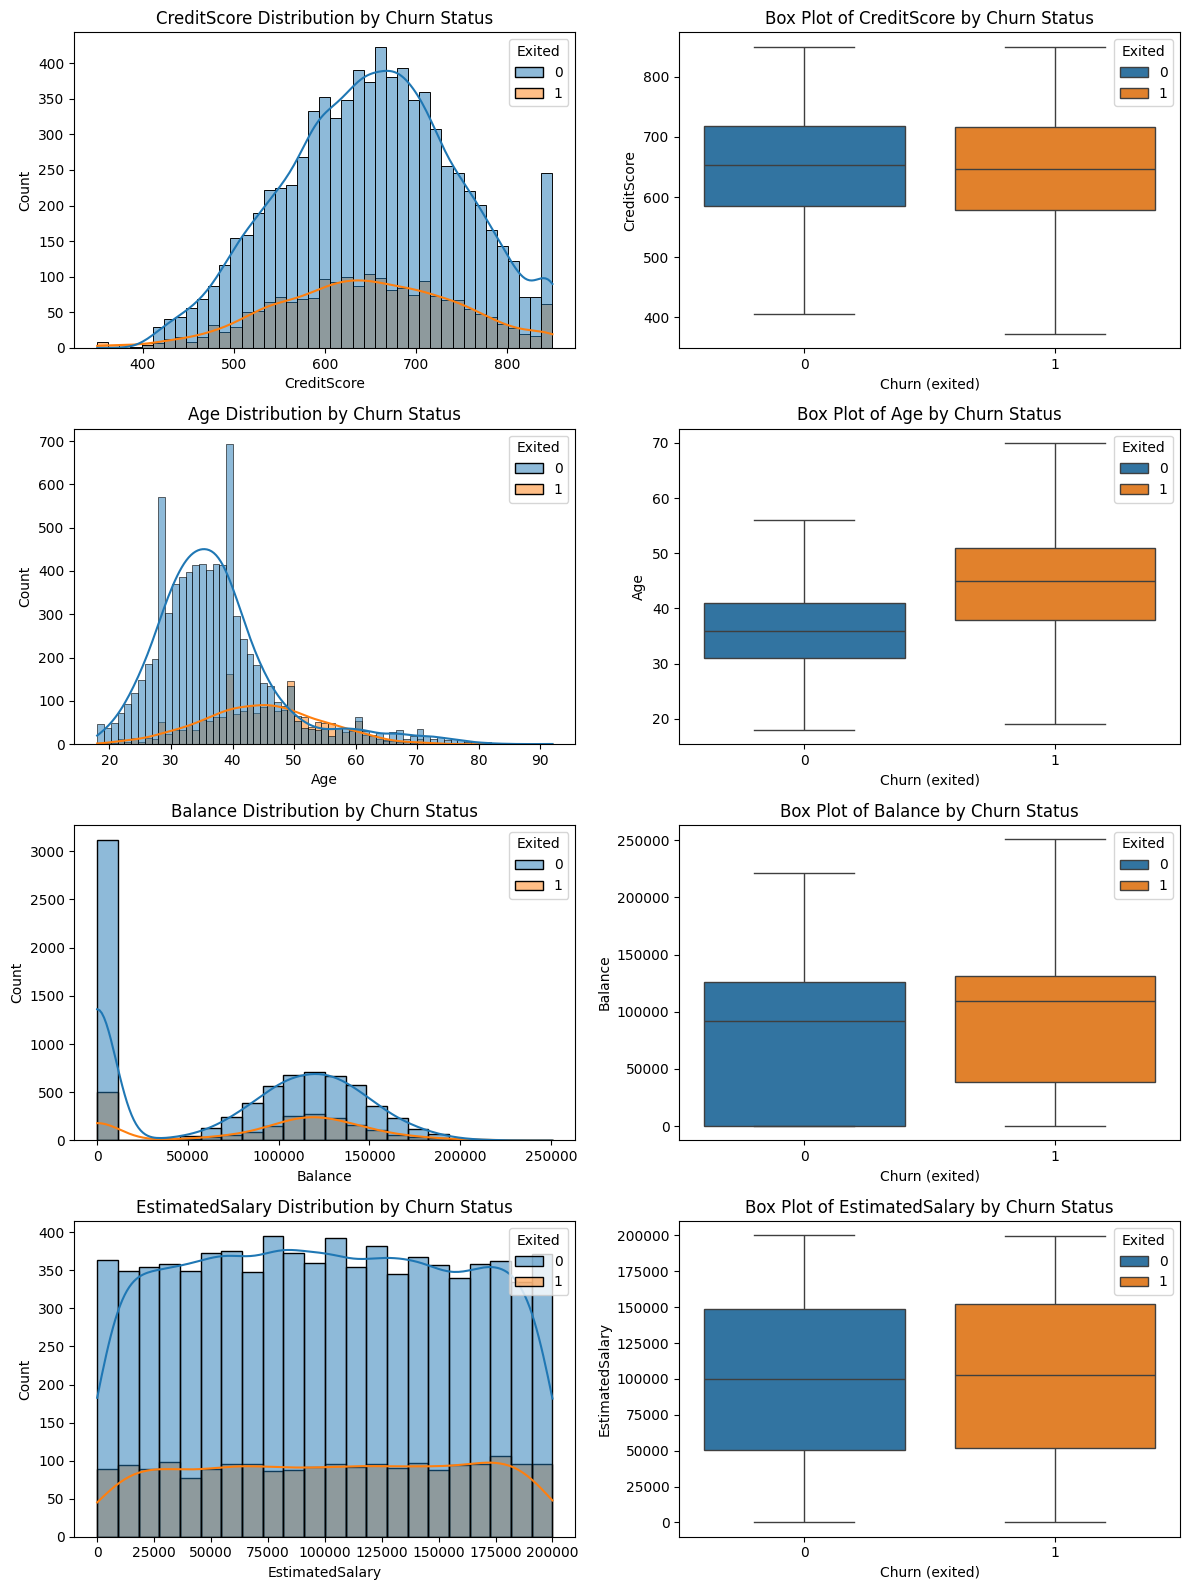

,Feature,t_stat,t_p,U_stat,U_p,Cohen's d,Mann r
0,CreditScore,2.7101,0.0067,8381083.0,0.0199,-0.0663,-0.0334
1,Age,-29.7668,0.0000,4345981.5,0.0000,0.7471,0.4641
2,Balance,-11.9362,0.0000,6849444.5,0.0000,0.3028,0.1555
3,EstimatedSalary,-1.2097,0.2264,7969863.0,0.2271,0.0300,0.0173


In [5]:
# Numerical features
plot_num_features_grid(df_raw, num_features, target='Exited')

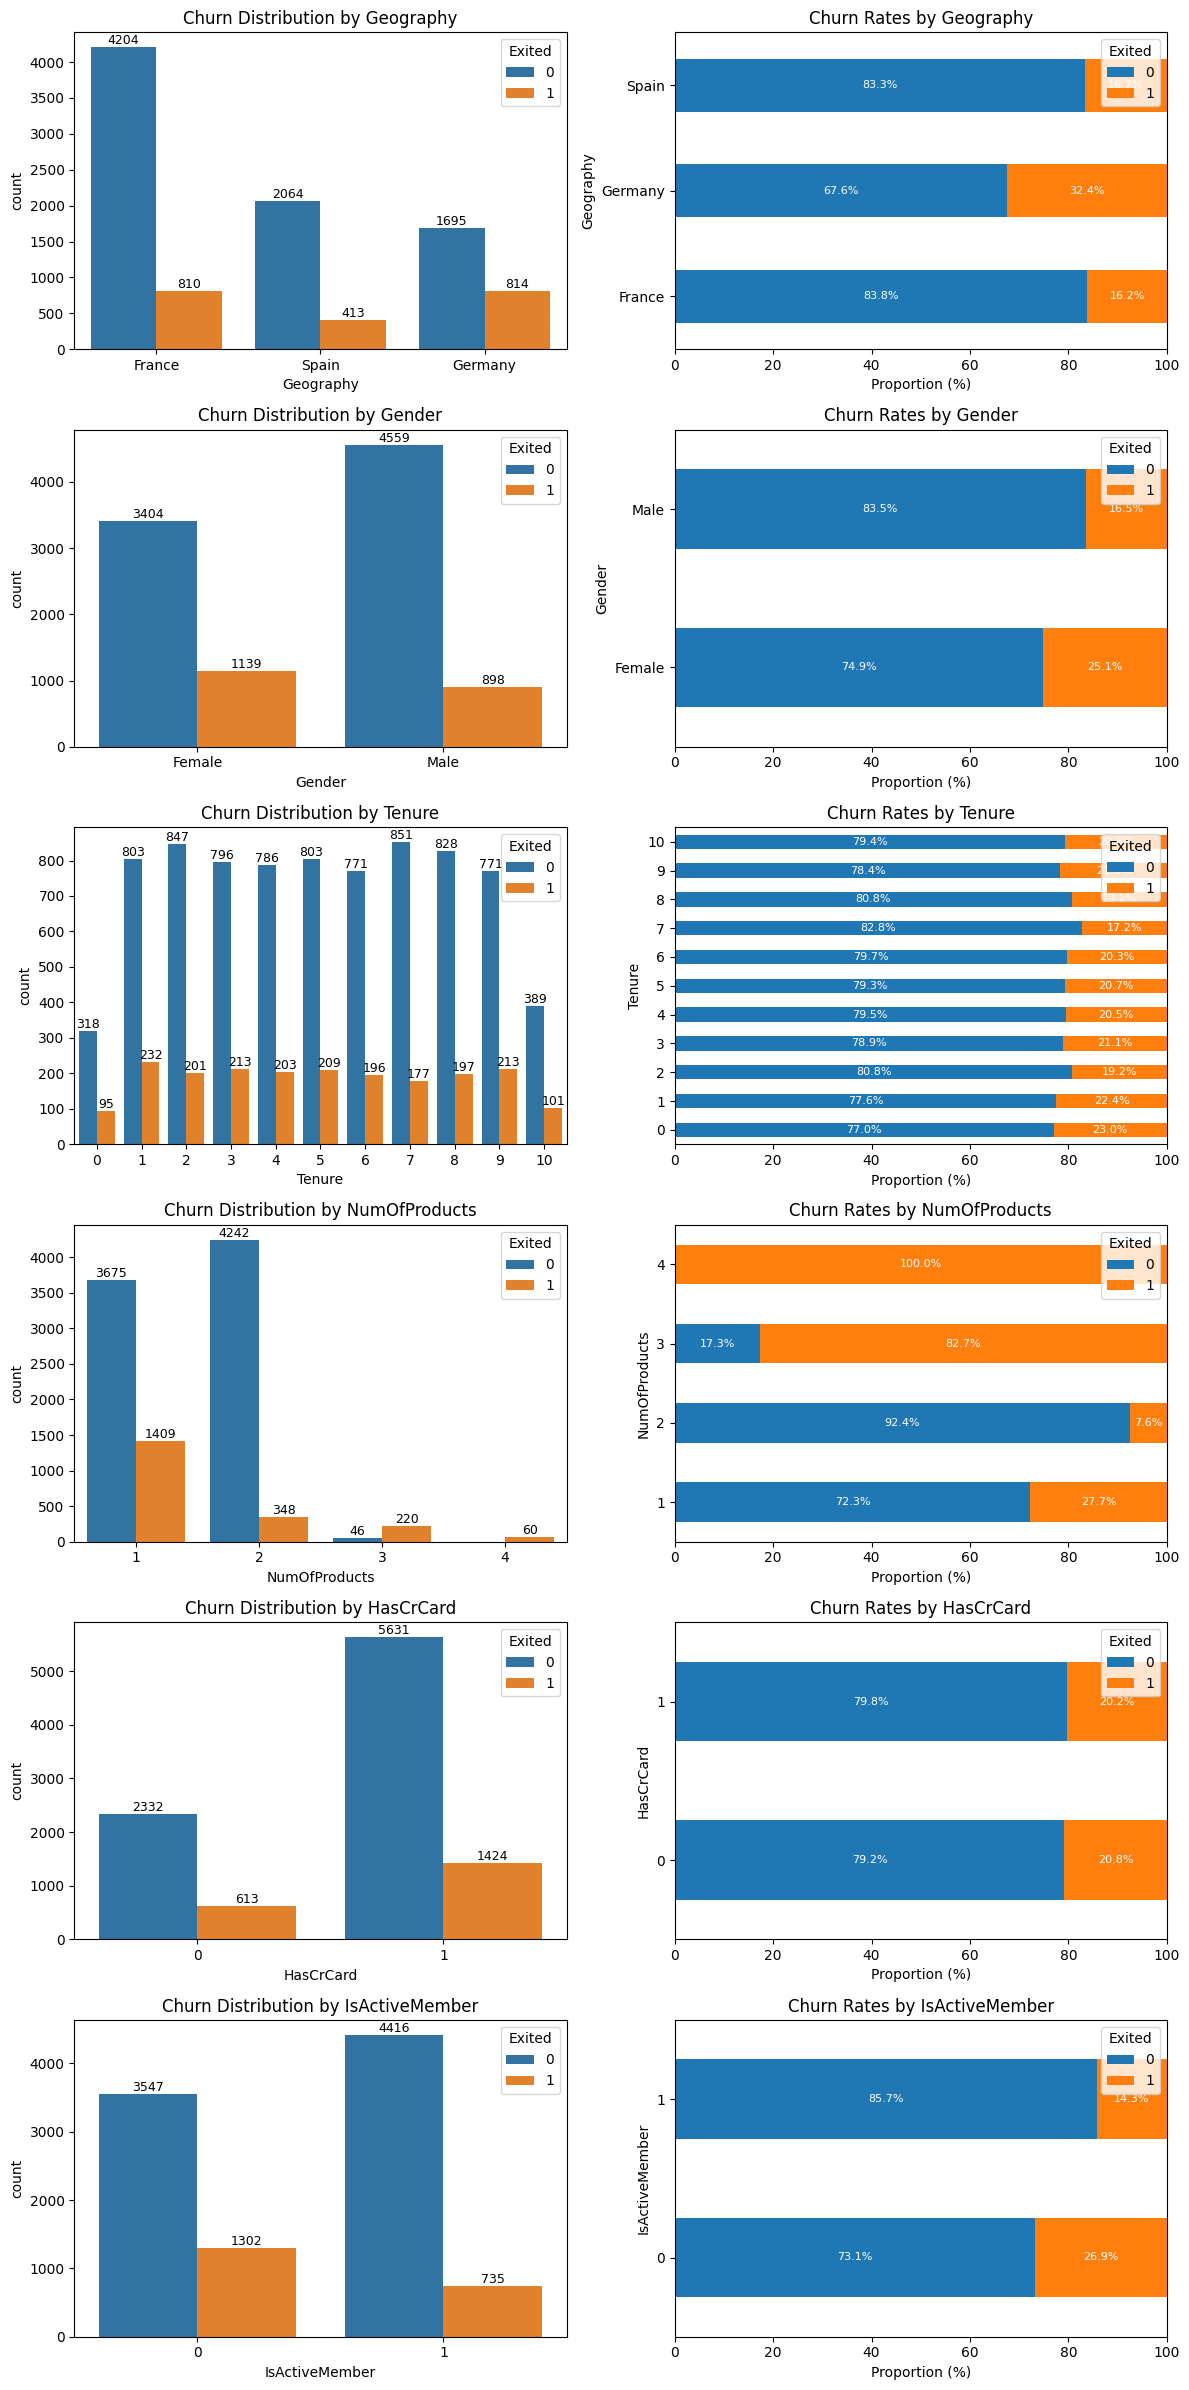

,Feature,Chi2,p,Cramer's V
0,Geography,301.2553,0.0000,0.1736
1,Gender,112.9186,0.0000,0.1063
2,Tenure,13.9004,0.1776,0.0373
3,NumOfProducts,1503.6294,0.0000,0.3878
4,HasCrCard,0.4713,0.4924,0.0069
5,IsActiveMember,242.9853,0.0000,0.1559


In [6]:
plot_bin_features_grid(df_raw, bin_features, 'Exited')

**Summary**
- *CreditScore* 
    - Right censored normal distribution most likely due to credit score being capped at 850.
    - Differences by churn status is minimal as evidence from the plot and effect sizing.
- *Age* 
    - Right skewed normal distribution with spikes at ages which are multiples of 10, possibly due to rounding during data entry.
    - Distribution of churners are shifted to a higher age group.
- *Balance*
    - Zero-inflated normal distribution
    - Differences by churn status is minimal except for high concentration of non-churners with zero balance.
- *EstimatedSalary*
    - Uniformly distributed.
    - Essentially no difference when stratified by churn status.
- *Geography*
    - 2:1:1 ratio between customers from france, germany, and spain respectively.
    - Customers from Germany are twice as likely to churn compared to thos from France and Spain.
- *Tenure*
    - Essentially evenly distributed with drop during year 0 and 10 for general and churned population.
- *NumOfProducts*
    - Majority of customers split between 1 or 2 products.
    - Churn rate varies widely with 3+ products having a extremely high churn rate, 1 product having above average churn rate, and 2 products having very low churn rate.
- *HasCrCard*
    - Approximatly 70% of customers have a credit card.
    - Status have equal proportion of churners.
- *IsActiveMember*
    - Slightly more active member.
    - Inactive members are slightly more likely to churn

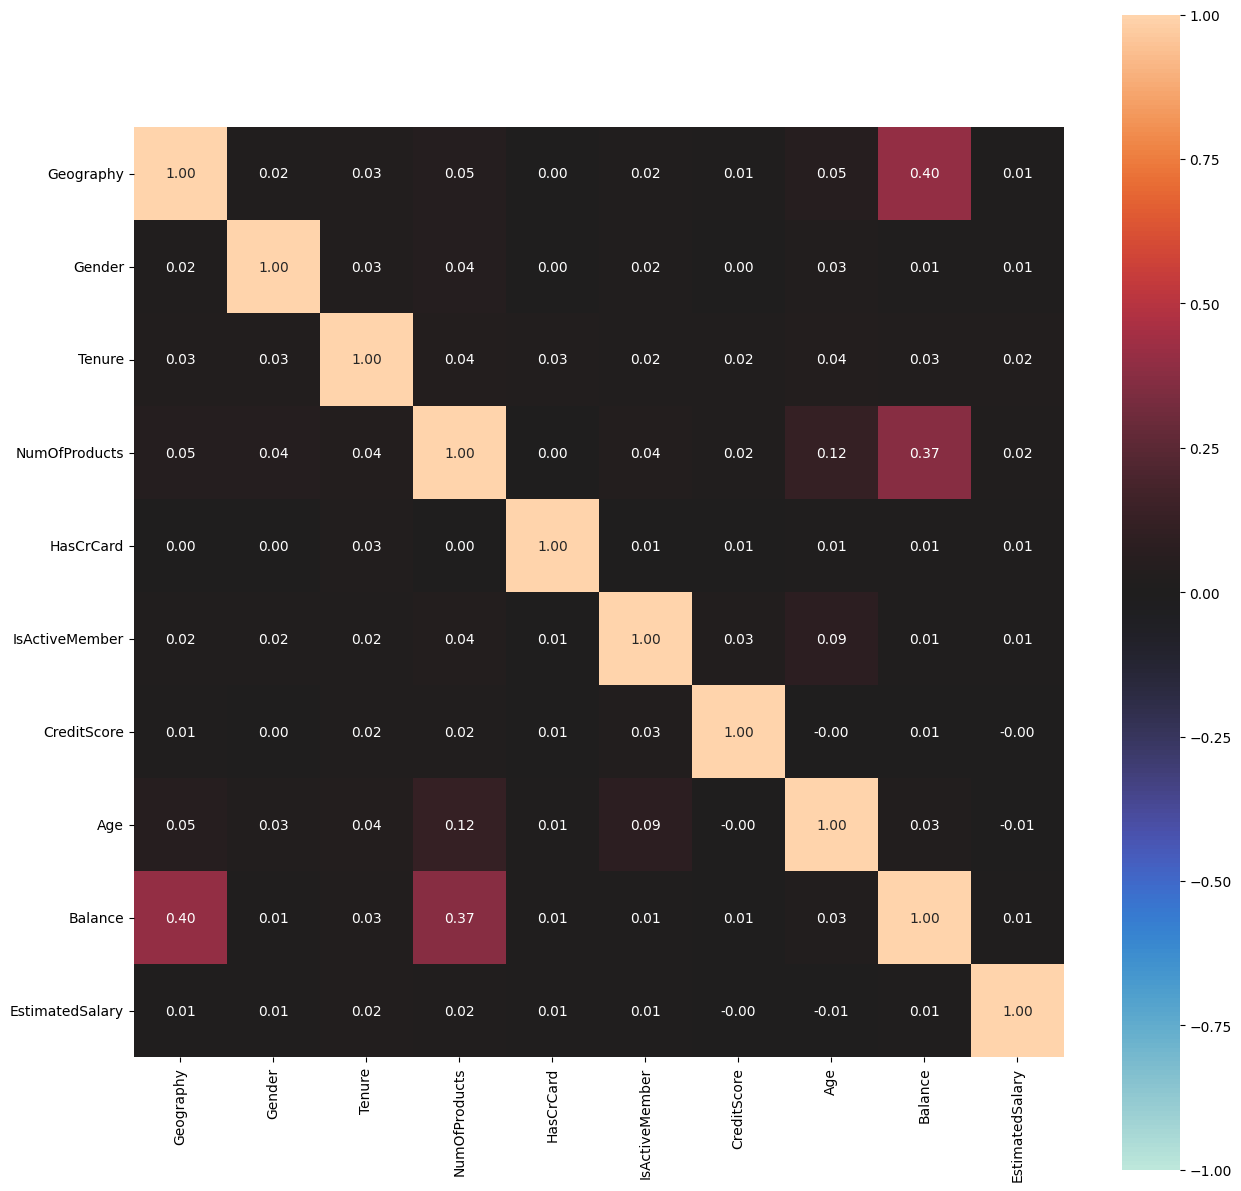

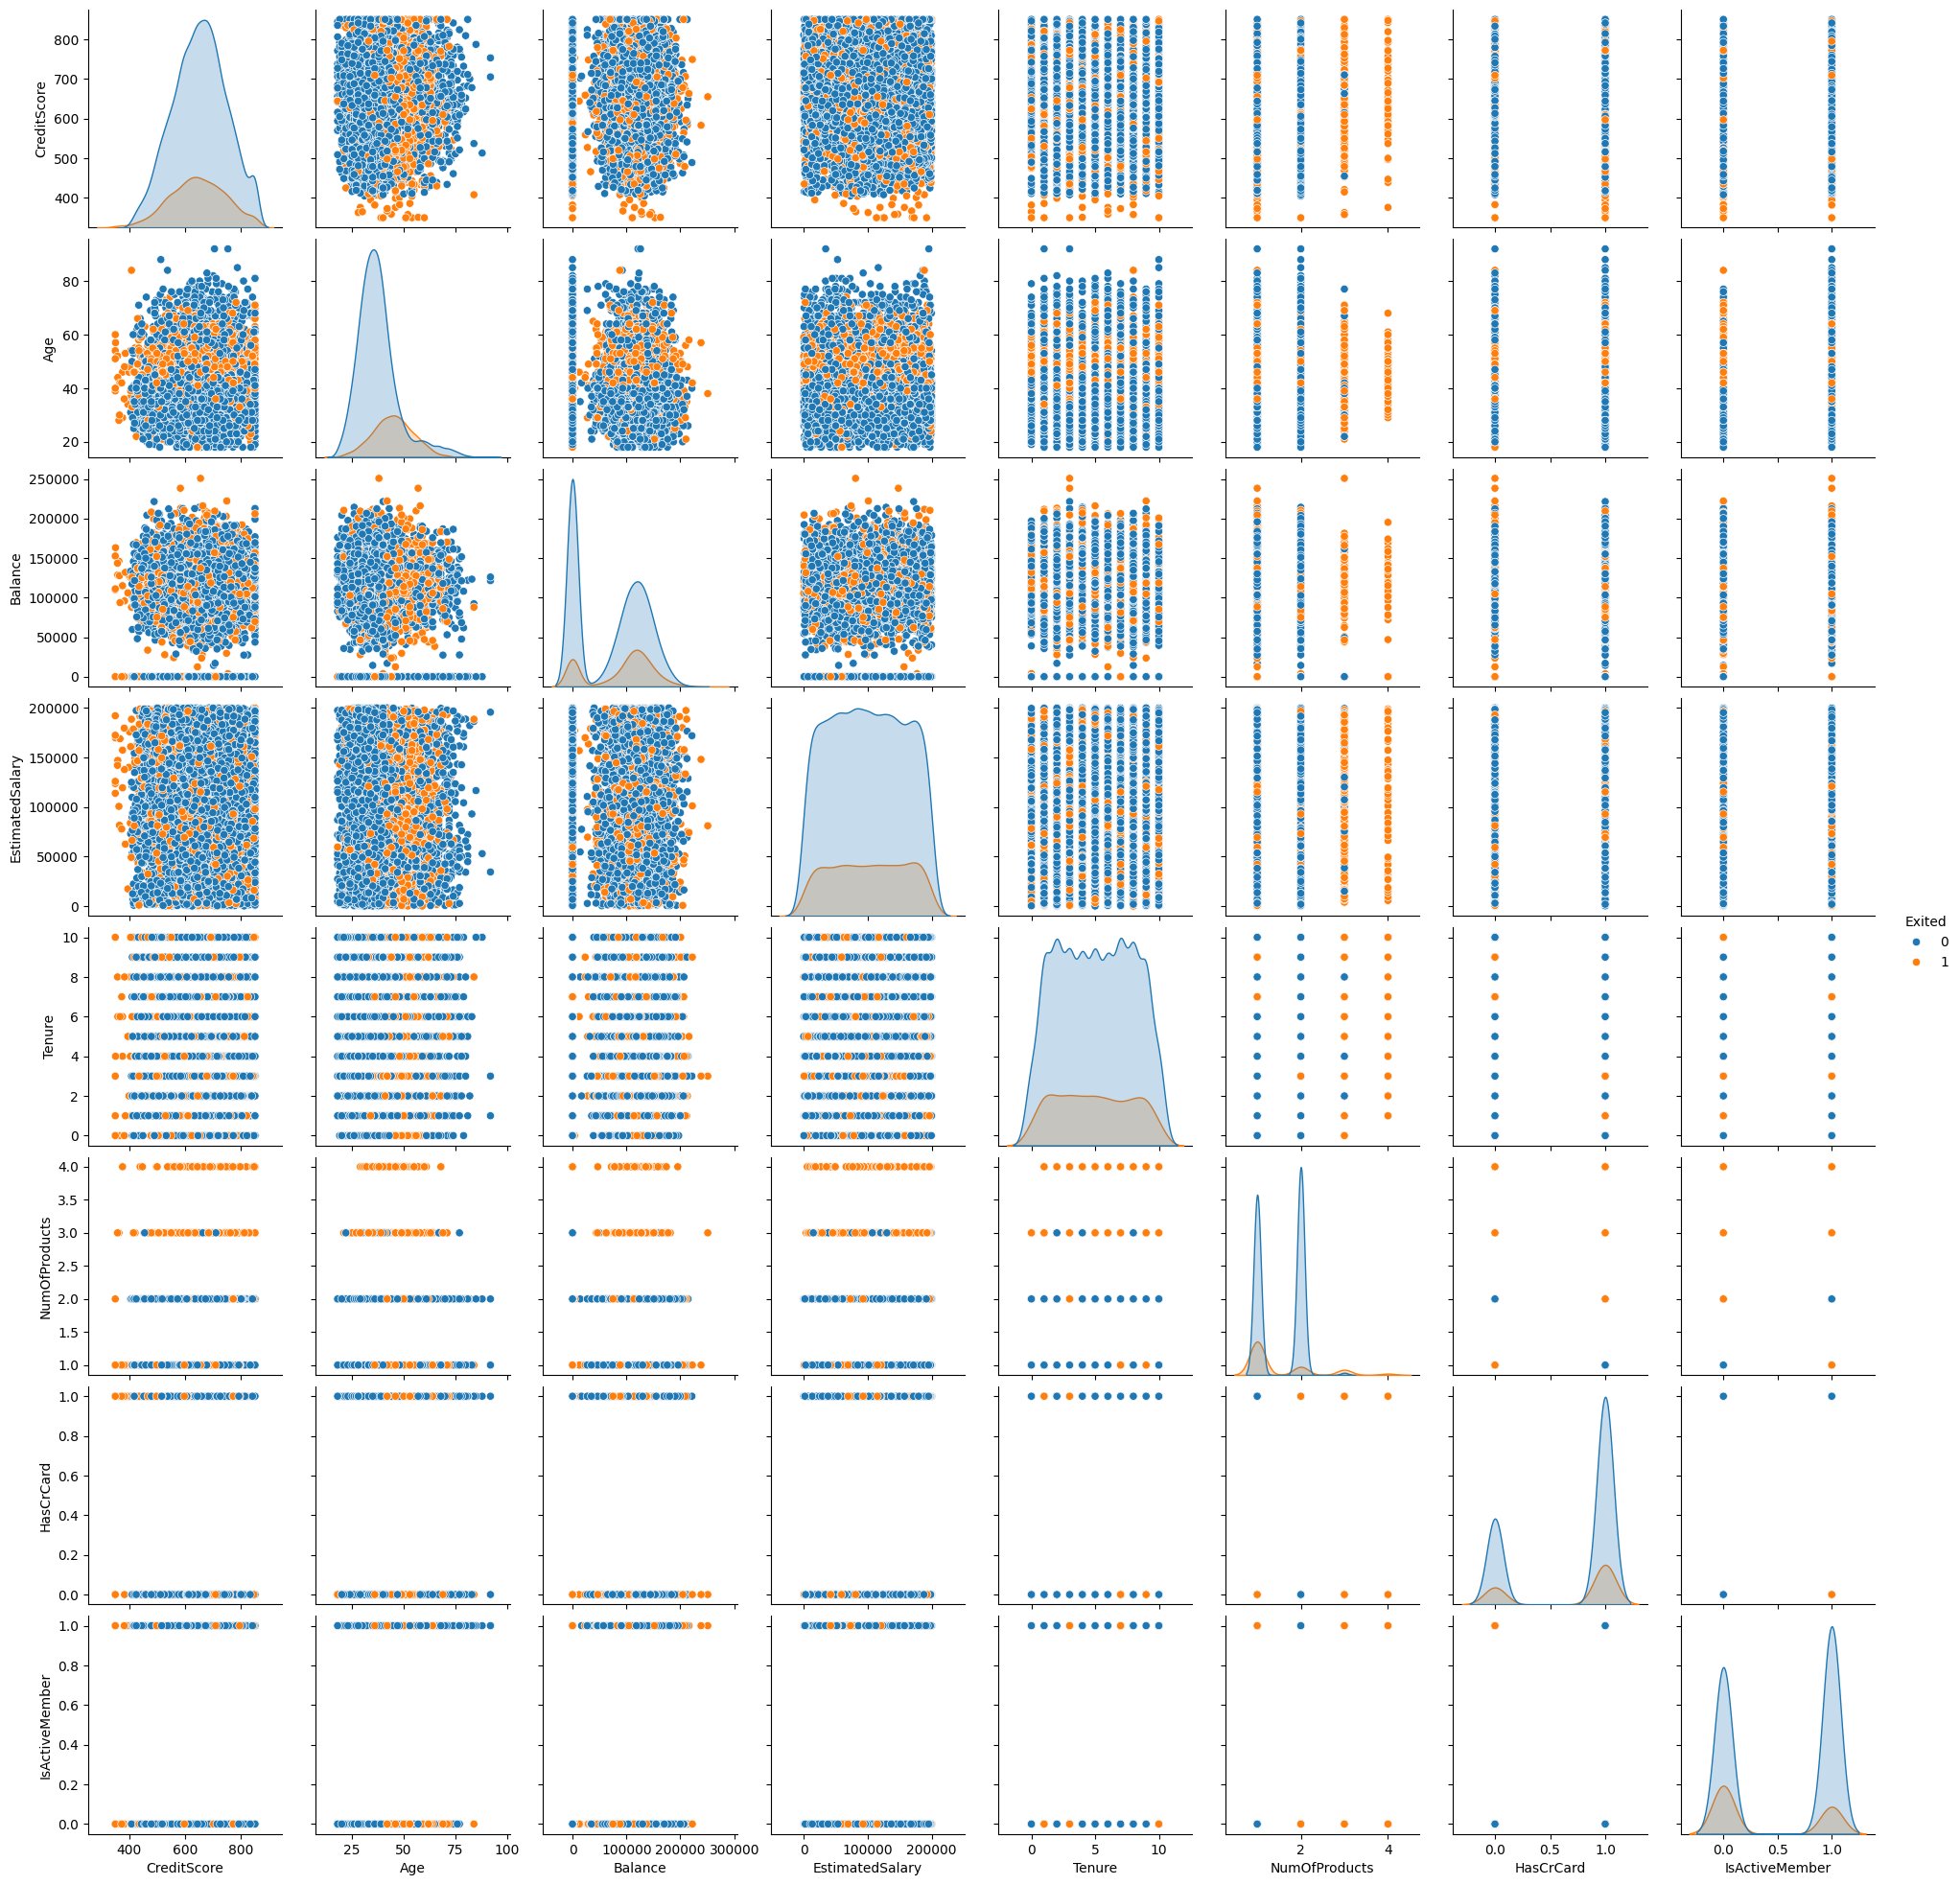

,Feature,VIF
0,const,95.601129
9,Tenure_2,3.176133
8,Tenure_1,3.145790
14,Tenure_7,3.135984
15,Tenure_8,3.132956
12,Tenure_5,3.107412
10,Tenure_3,3.103188
11,Tenure_4,3.064470
16,Tenure_9,3.057559
13,Tenure_6,3.022936


In [7]:
check_multicolinearity(df_raw, num_features, bin_features, 'Exited')

**Summary**
- There is a small amount of pair wise correlation between Balance and NumOfProducts as well as Balance and Geography.
- From the VIF table we see that most features are not multicollinear with other features or there is a negligible amount.